## ##### IMPORT PACKAGES AND DEFINE FUNCTIONS \#####

In [1]:
# ----- IMPORT PACKAGES -----
# Arrays and operations ...
import numpy as np

# Plotting ...
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cv2

# Parallel computations ...
import concurrent.futures
import numba
from numba import prange, jit

# Progress bars and text ...
from tqdm.notebook import tqdm
from IPython.display import clear_output, display


# ----- DEFINE FUNCTIONS -----
def generate_frame_lims(initial_center: tuple[float, float], final_center: tuple[float, float], initial_size: float, size_decay: float, num_frames: int) -> tuple[np.ndarray, np.ndarray]:
    """Return a list of x and y limits for each frame given the initial and final center points,
    the initial frame size, the number of frames, and the decay rate for the size."""
    
    # Unpack initial and final center locations ...
    x0, y0 = initial_center
    xend, yend = final_center
    
    # Generate arrays of x and y coordinates for each frames' center location ...
    x_centers = xend - (size_decay ** np.arange(num_frames)) * (xend - x0)
    y_centers = yend - (size_decay ** np.arange(num_frames)) * (yend - y0)
    
    # Calculate frame sizes using initial size and the frame size decay ...
    frame_sizes = initial_size*(size_decay**np.arange(num_frames))
    
    # Generate arrays of x and y limits for each frame ...
    x_lims = np.stack([x_centers - frame_sizes/2, x_centers + frame_sizes/2], axis = 1)
    y_lims = np.stack([y_centers - frame_sizes/2, y_centers + frame_sizes/2], axis = 1)
   
    return x_lims, y_lims


def complex_array(x_lims: list[float, float], y_lims: list[float, float], n_pixels: int) -> np.ndarray:
    """Generate a complex array given the minimum and maximum values of the real and imaginary axes, and the number of pixels in the final image."""
    
    # Unpack frame limits ...
    x_min, x_max = x_lims
    y_min, y_max = y_lims
    
    # Generate real and imaginary components of complex array ...
    real = np.linspace(x_min, x_max, n_pixels)
    imag = np.linspace(y_min, y_max, n_pixels)
    
    # Return complex array ...
    return real[np.newaxis, :] + imag[:, np.newaxis]*1j

# Old version of find stable (more pythonic, but far too slow) ...
#def find_stable(comp_matrix: np.ndarray, num_iterations: int) -> np.ndarray:
#    """Return a boolean array of elements in the complex matrix that remain bounded after num_iterations iterations."""
#    z = 0
#    for _ in range(num_iterations):
#        z = z**2 + comp_matrix
#        
#    return abs(z) <= 2

@jit(nopython = True, parallel = True)
def find_stable(c_array: np.ndarray, iterations_to_bound: int) -> np.ndarray:
    """
    Return a boolean array of elements in a complex matrix 
    that remain bounded after iterations_to_bound many iterations.
    """
    # Get the height and width of the input array 
    # and initialise an output array of the same size ...
    h, w = c_array.shape
    output = np.full((h, w), True)
    
    # Iterate over the indices of the input array in parallel
    for i in prange(h):
        for j in prange(w):
            # Initialize the (i, j)th complex number z to zero, and 
            # get the corresponding (i, j)th input complex number c ...
            z = 0j
            c = c_array[i, j]
            
            # Iterate up to the specified number of iterations
            for k in range(iterations_to_bound):
                # Update z according to the Mandelbrot iteration rule
                z = z**2 + c
                
                # If the magnitude of z exceeds 2, mark this input value as unbounded
                if abs(z) > 2:
                    output[i, j] = False
                    break
    
    # Return the output array
    return output

# Define the parallel worker function ...
def parallel_worker(args: tuple[np.ndarray, np.ndarray]) -> np.ndarray:
    """Given x and y limits, compute the complex array and find stable points for the Mandelbrot set"""
    # Extract limits and generate the complex array ...
    x_lims, y_lims = args
    c_array = complex_array(x_lims, y_lims, frame_resolution)
    
    # Return the stable points ...
    return find_stable(c_array, iterations_to_bound)

## ##### GENERATE FRAMES \#####

In [2]:
# ----- GENERATE THE FRAMES FOR THE MANDELBROT SET ANIMATION -----
# x, y coordinates of start and end center locations ...
initial_center = (-0.5, 0.0)
final_center = (-1.41, 0.0)

# Frame sizing ...
initial_size = 3.0
size_decay = 0.975

# Definition of the number of frames to render, the resolution of each frame in pixels, 
# and the number of iterations to perform to check for bounded values ...
num_frames, frame_resolution, iterations_to_bound = 450, 2000, 100

# Calculate the x and y limits for each frame ...
x_lims_list, y_lims_list = generate_frame_lims(initial_center, final_center, initial_size, size_decay, num_frames)

# Create a thread pool with 4 workers ..
with concurrent.futures.ThreadPoolExecutor(max_workers = 4) as executor:
    # Map the parallel worker function to the frame limit inputs ...
    futures = [executor.submit(parallel_worker, args) for args in zip(x_lims_list, y_lims_list)]
    
    # Display a progress bar ...
    for f in tqdm(concurrent.futures.as_completed(futures), total = len(futures)):
        pass
    
    # Collect the results ...
    frames = [f.result() for f in futures]

  0%|          | 0/450 [00:00<?, ?it/s]

## ##### CREATE ANIMATION \#####

In [6]:
# Convert boolean frame arrays to grayscale images ...
frames_gray = [(frame * 255).astype(np.uint8) for frame in frames]

# Get shape of frames ...
height, width = frames_gray[0].shape

# Define output video codec ...
fourcc = cv2.VideoWriter_fourcc(*'WMV2')

# Create video writer object ...
fps = 25
out = cv2.VideoWriter('Mandelbrot_Set.avi', fourcc, fps, (width, height), isColor = False)

# Write frames to video ...
for frame in tqdm(frames_gray):
    out.write(frame)

# Release video writer object ...
out.release()

  0%|          | 0/450 [00:00<?, ?it/s]

Generating frame 499 of 500 ...


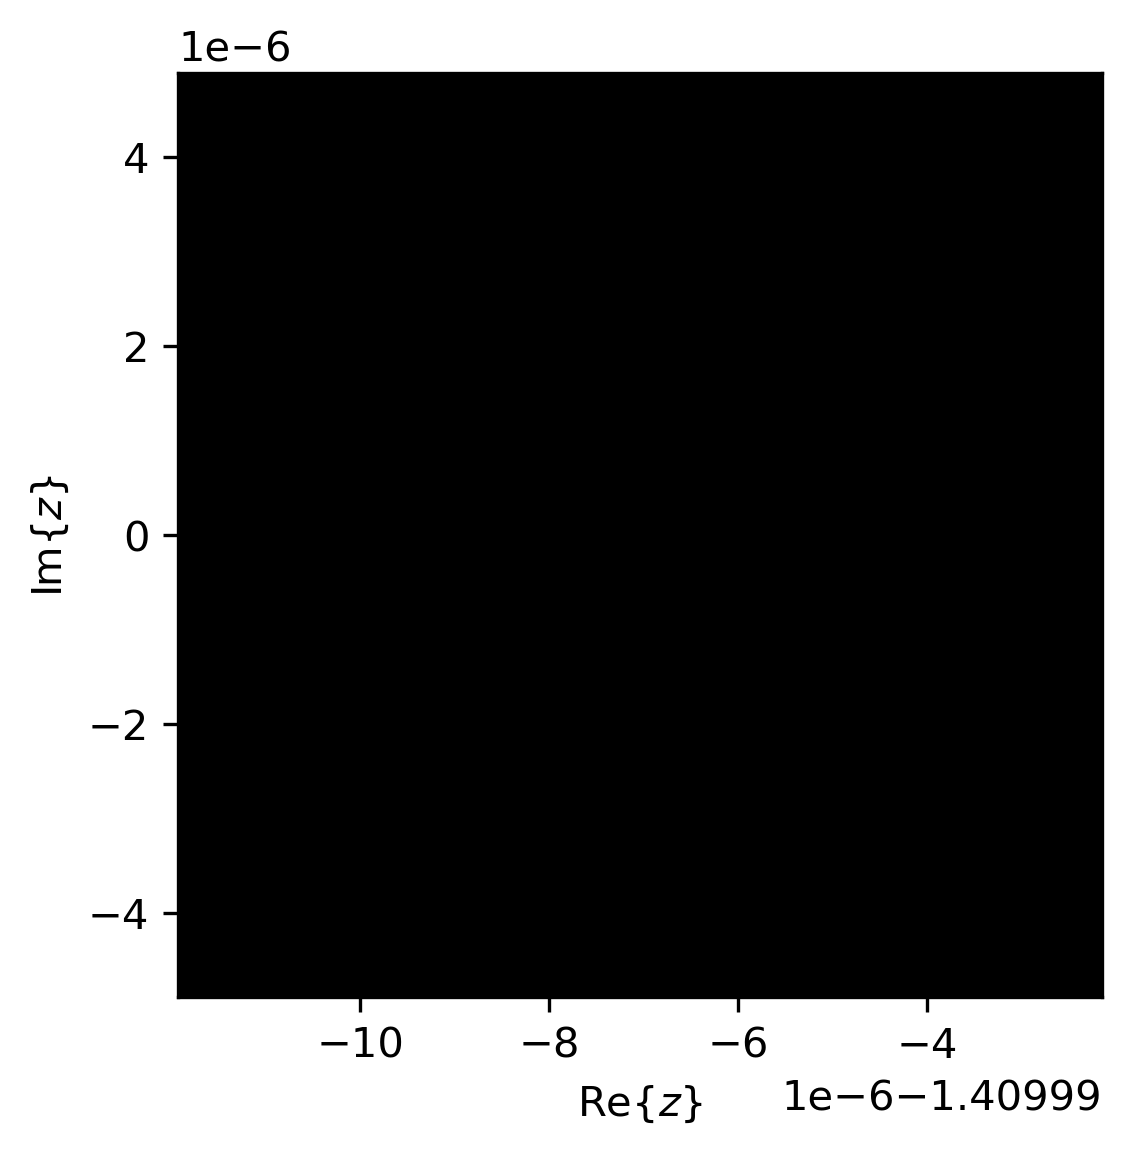

In [9]:
# Set up plot showing first frame of mandelbrot set ...
fig, ax = plt.subplots(1, dpi = 300)
img = ax.imshow(
    frames[0], cmap = 'binary', 
    extent = [x_lims_list[0, 0], x_lims_list[0, 1], y_lims_list[0, 0], y_lims_list[0, 1]]
)

# Add axis labels ...
plt.xlabel(r'$\mathrm{Re}\{z\}$')
plt.ylabel(r'$\mathrm{Im}\{z\}$')

def update(idx: int):
    # Print out progress message ...
    clear_output(wait = True)
    print(f'Generating frame {idx} of {len(frames)} ...')
    
    # Set the image data and axis ticks ...
    img.set(
        data = frames[idx],
        extent = [x_lims_list[idx, 0], x_lims_list[idx, 1], y_lims_list[idx, 0], y_lims_list[idx, 1]]
    )
    
    # Return imshow handle ...
    return [img]

# Create the animation ...
anim = FuncAnimation(fig, update, frames=len(frames), blit = True)

# Save the animation ...
anim.save('mandelbrot_set_plot.avi', fps = 25, extra_args = ['-vcodec', 'libx264'])